In [1]:
import os

In [9]:
import numpy as np
import pandas as pd
import glob
import random

from sklearn import metrics
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, StratifiedShuffleSplit, KFold
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score
import fcalc
from mlxtend.feature_selection import SequentialFeatureSelector
import winsound
import seaborn as snx
import xgboost as xgb
random.seed(42)

os.getcwd()

'C:\\Users\\HP pavilion X360\\Desktop\\OSDA\\big_homework'

# Aphasia_BCI

In [10]:
data = pd.read_csv('bci_s005.csv')

In [12]:
y = (data['target'].values >=1).astype(int)
data.drop(['Unnamed: 0', 'target'], axis = 1, inplace = True)
X = data.values

X = X[:, :150] + X[:, 150:]

print(np.unique(y, return_counts = True))

(array([0, 1]), array([3370,  767], dtype=int64))


In [13]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size = 0.2, stratify = y)

In [14]:
stsc = StandardScaler()
stsc.fit(X_train)
train = stsc.transform(X_train)
test = stsc.transform(X_test)

train.shape

(3309, 150)

In [18]:
kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile', subsample=None).fit(train)
new_train = pd.DataFrame(kbins.transform(train), columns = pd.DataFrame(train).columns)
new_test = pd.DataFrame(kbins.transform(test), columns = pd.DataFrame(test).columns)

ohe = OneHotEncoder(drop = 'first').fit(new_train)
ohe_train = ohe.transform(new_train).toarray().astype(int)
ohe_test = ohe.transform(new_test).toarray().astype(int)

print(ohe_train.shape, ohe_test.shape)

(3309, 300) (828, 300)


## 1. KNN

Best params: {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}


<Axes: >

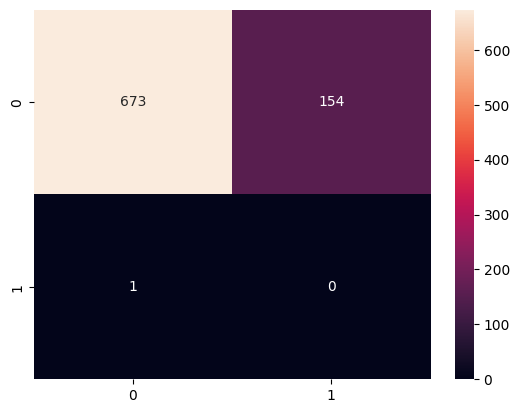

In [19]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(1, 30, 1), 'metric': ('euclidean', 'manhattan'),
             'weights':('uniform', 'distance')}
grid = GridSearchCV(knn, parameters, cv = 4)

grid.fit(train, y_train)
print(f'Best params: {grid.best_params_}')
knn_pred = KNeighborsClassifier(metric = grid.best_params_['metric'], n_neighbors = grid.best_params_['n_neighbors'],
                               weights = grid.best_params_['weights'])
knn_pred.fit(train, y_train)

y_pred = knn_pred.predict(test)

contingency_matrix = metrics.cluster.contingency_matrix(y_pred, y_test)
snx.heatmap(contingency_matrix, annot = True, fmt='')

In [20]:
print(f'Accuracy: {metrics.accuracy_score(y_pred = y_pred, y_true = y_test)}')
print(f'f1: {metrics.f1_score(y_pred = y_pred, y_true = y_test, average = "macro")}')
print(f'recall: {metrics.recall_score(y_pred = y_pred, y_true = y_test, average = "macro")}')

Accuracy: 0.8128019323671497
f1: 0.44836775483011326
recall: 0.4992581602373887


## 2. Logistic Regression

Best params: {'C': 3.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


<Axes: >

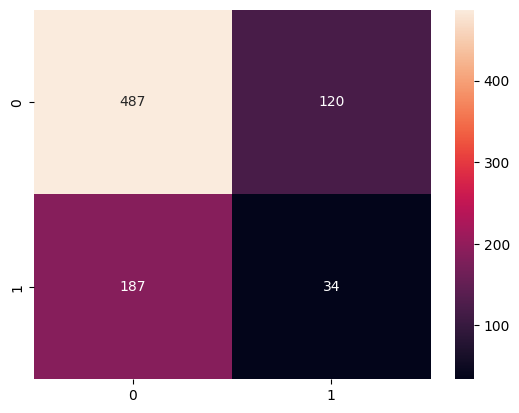

In [21]:
lr = LogisticRegression(max_iter = 10000, random_state = 42)
parameters = {'C':np.arange(0.1, 5, 1), 'penalty': ('l2', 'l1'),
             'class_weight': ['balanced'],
             'solver' : ['saga', 'liblinear']}
grid = GridSearchCV(lr, parameters, cv = 4, n_jobs = -2)

grid.fit(train, y_train)
print(f'Best params: {grid.best_params_}')

lr_pred = LogisticRegression(C = grid.best_params_['C'], penalty = grid.best_params_['penalty'],
                               class_weight = grid.best_params_['class_weight'],
                            solver = grid.best_params_['solver'])
lr_pred.fit(train, y_train)

y_pred = lr_pred.predict_proba(test)[:, 1] > .55

contingency_matrix = metrics.cluster.contingency_matrix(1*y_pred,
                                                      y_test)
snx.heatmap(contingency_matrix, annot = True, fmt='')

In [22]:
# print(f'Logistic Regression accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Logistic Regression recall: {metrics.recall_score(y_pred = y_pred, y_true = y_test, average = "macro")}')
print(f'Logistic Regression f1: {f1_score(y_test, y_pred, average = "weighted")}')

Logistic Regression recall: 0.4716655747813018
Logistic Regression f1: 0.6526531883680851


## 3.a XGBoost

In [23]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split


data_dmatrix = xgb.DMatrix(data=train, label=y_train)
params = {'objective':'binary:logistic','eval_metric':'logloss',
          'eta':0.01,
          'subsample':0.1}
def fit_and_score(estimator, X_train, X_test, y_train, y_test):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return estimator, train_score, test_score


cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=94)

In [24]:
from sklearn.base import clone
clf = xgb.XGBClassifier(tree_method="hist", nfold=4, metrics = 'logloss', seed=42)

resutls = {}

for train_id, test_id in cv.split(train, y_train):
    X_train = train[train_id]
    X_test = train[test_id]
    y_train_cv = y_train[train_id]
    y_test_cv = y_train[test_id]
    est, train_score, test_score = fit_and_score(
        clone(clf), X_train, X_test, y_train_cv, y_test_cv
    )
    resutls[est] = (train_score, test_score)

params = {'eta':np.linspace(0.1, 1.0, 2),
          'subsample':[0.5, 0.7],
          'max_depth': [10, 20],
          'eval_metric':['logloss'],
          'alpha':np.linspace(1, 25, 5),
         'objective':['binary:logistic', 'reg:logistic']}

grid = GridSearchCV(clf, params, cv = 4,  n_jobs = -2)

grid.fit(train, y_train)
print(f'Best params: {grid.best_params_}')

[0]	validation_0-logloss:0.48469
[1]	validation_0-logloss:0.48030
[2]	validation_0-logloss:0.47894
[3]	validation_0-logloss:0.48412
[4]	validation_0-logloss:0.48693


C:\Users\HP pavilion X360\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:53:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "metrics", "nfold" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-logloss:0.48815
[6]	validation_0-logloss:0.48993
[7]	validation_0-logloss:0.48945
[8]	validation_0-logloss:0.49001
[9]	validation_0-logloss:0.49771
[10]	validation_0-logloss:0.49922
[11]	validation_0-logloss:0.50220
[12]	validation_0-logloss:0.50337
[13]	validation_0-logloss:0.50571
[14]	validation_0-logloss:0.50821
[15]	validation_0-logloss:0.51133
[16]	validation_0-logloss:0.51670
[17]	validation_0-logloss:0.52181
[18]	validation_0-logloss:0.52447
[19]	validation_0-logloss:0.52597
[20]	validation_0-logloss:0.52770
[21]	validation_0-logloss:0.53382
[22]	validation_0-logloss:0.53694
[23]	validation_0-logloss:0.53914
[24]	validation_0-logloss:0.53770
[25]	validation_0-logloss:0.54049
[26]	validation_0-logloss:0.54260
[27]	validation_0-logloss:0.54865
[28]	validation_0-logloss:0.55174
[29]	validation_0-logloss:0.55276
[30]	validation_0-logloss:0.55388
[31]	validation_0-logloss:0.55492
[32]	validation_0-logloss:0.55691
[33]	validation_0-logloss:0.55744
[34]	validation_0-l

C:\Users\HP pavilion X360\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:53:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "metrics", "nfold" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-logloss:0.49695
[7]	validation_0-logloss:0.50114
[8]	validation_0-logloss:0.50415
[9]	validation_0-logloss:0.50180
[10]	validation_0-logloss:0.50311
[11]	validation_0-logloss:0.50557
[12]	validation_0-logloss:0.50865
[13]	validation_0-logloss:0.50947
[14]	validation_0-logloss:0.51114
[15]	validation_0-logloss:0.51485
[16]	validation_0-logloss:0.51670
[17]	validation_0-logloss:0.52125
[18]	validation_0-logloss:0.51935
[19]	validation_0-logloss:0.52192
[20]	validation_0-logloss:0.52528
[21]	validation_0-logloss:0.52777
[22]	validation_0-logloss:0.53016
[23]	validation_0-logloss:0.53113
[24]	validation_0-logloss:0.52984
[25]	validation_0-logloss:0.53162
[26]	validation_0-logloss:0.53263
[27]	validation_0-logloss:0.53784
[28]	validation_0-logloss:0.53983
[29]	validation_0-logloss:0.54000
[30]	validation_0-logloss:0.54158
[31]	validation_0-logloss:0.54372
[32]	validation_0-logloss:0.54900
[33]	validation_0-logloss:0.55436
[34]	validation_0-logloss:0.55640
[35]	validation_0-

C:\Users\HP pavilion X360\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:53:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "metrics", "nfold" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-logloss:0.51896
[8]	validation_0-logloss:0.52570
[9]	validation_0-logloss:0.53104
[10]	validation_0-logloss:0.53654
[11]	validation_0-logloss:0.53702
[12]	validation_0-logloss:0.53694
[13]	validation_0-logloss:0.53802
[14]	validation_0-logloss:0.54291
[15]	validation_0-logloss:0.55384
[16]	validation_0-logloss:0.55411
[17]	validation_0-logloss:0.55157
[18]	validation_0-logloss:0.55348
[19]	validation_0-logloss:0.55592
[20]	validation_0-logloss:0.55633
[21]	validation_0-logloss:0.56042
[22]	validation_0-logloss:0.56113
[23]	validation_0-logloss:0.56596
[24]	validation_0-logloss:0.57003
[25]	validation_0-logloss:0.57640
[26]	validation_0-logloss:0.57496
[27]	validation_0-logloss:0.57427
[28]	validation_0-logloss:0.57404
[29]	validation_0-logloss:0.58104
[30]	validation_0-logloss:0.58314
[31]	validation_0-logloss:0.58543
[32]	validation_0-logloss:0.58657
[33]	validation_0-logloss:0.59010
[34]	validation_0-logloss:0.59169
[35]	validation_0-logloss:0.59561
[36]	validation_0

C:\Users\HP pavilion X360\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:53:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "metrics", "nfold" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-logloss:0.49337
[8]	validation_0-logloss:0.49284
[9]	validation_0-logloss:0.49558
[10]	validation_0-logloss:0.49971
[11]	validation_0-logloss:0.50285
[12]	validation_0-logloss:0.50501
[13]	validation_0-logloss:0.50513
[14]	validation_0-logloss:0.50826
[15]	validation_0-logloss:0.50780
[16]	validation_0-logloss:0.50836
[17]	validation_0-logloss:0.50849
[18]	validation_0-logloss:0.51041
[19]	validation_0-logloss:0.51205
[20]	validation_0-logloss:0.51851
[21]	validation_0-logloss:0.52354
[22]	validation_0-logloss:0.52501
[23]	validation_0-logloss:0.52505
[24]	validation_0-logloss:0.52750
[25]	validation_0-logloss:0.53269
[26]	validation_0-logloss:0.53538
[27]	validation_0-logloss:0.53731
[28]	validation_0-logloss:0.53840
[29]	validation_0-logloss:0.54178
[30]	validation_0-logloss:0.54524
[31]	validation_0-logloss:0.54726
[32]	validation_0-logloss:0.54984
[33]	validation_0-logloss:0.55030
[34]	validation_0-logloss:0.55173
[35]	validation_0-logloss:0.55438
[36]	validation_0

C:\Users\HP pavilion X360\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:57:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "metrics", "nfold" } are not used.

  warnings.warn(smsg, UserWarning)


Best params: {'alpha': 25.0, 'eta': 0.1, 'eval_metric': 'logloss', 'max_depth': 10, 'objective': 'binary:logistic', 'subsample': 0.5}


<Axes: >

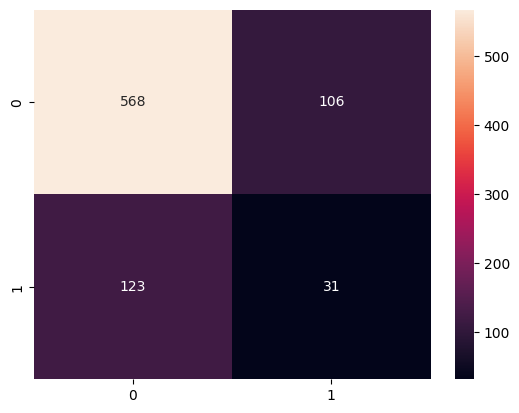

In [25]:
xgb_reg = xgb.XGBClassifier(objective= grid.best_params_['objective'],
                           eval_metric = grid.best_params_['eval_metric'],
                           eta = grid.best_params_['eta'],
                           subsample = grid.best_params_['subsample'],
                           max_depth = grid.best_params_['max_depth'],
                           alpha = grid.best_params_['alpha']-10)

xgb_reg.fit(train, y_train)
y_pred = xgb_reg.predict_proba(test)[:, 1] > .25
contingency_matrix = metrics.cluster.contingency_matrix(y_test, y_pred)
snx.heatmap(contingency_matrix, annot = True, fmt='')

In [26]:
print(f'NB accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'NB f1: {f1_score(y_test, y_pred, average = "macro")}')

NB accuracy: 0.7234299516908212
NB f1: 0.5226464257392093


## 4. Random Forest

Best params: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 23, 'min_samples_split': 3}


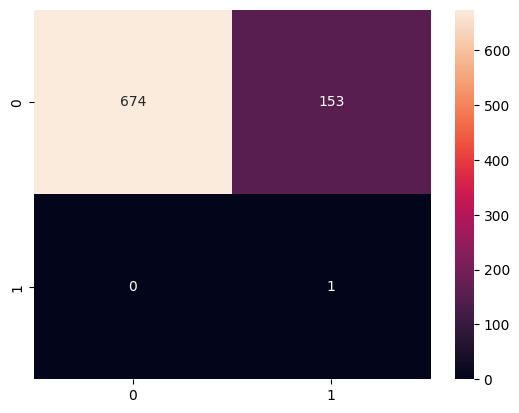

In [27]:
rfc = RandomForestClassifier(random_state = 42, n_jobs = -2)
parameters = {'max_depth':np.arange(3, 30, 5),
             'criterion':['gini', 'entropy'], 'min_samples_split': np.arange(3, 30, 5),
             'class_weight':['balanced', 'balanced_subsample']}
grid = GridSearchCV(rfc, parameters, cv = 4)

grid.fit(train, y_train)
print(f'Best params: {grid.best_params_}')
rfc_pred = RandomForestClassifier(random_state = 42, max_depth = grid.best_params_['max_depth'],
                                 criterion = grid.best_params_['criterion'],
                                 min_samples_split = grid.best_params_['min_samples_split'],
                                 class_weight = grid.best_params_['class_weight'])
rfc_pred.fit(train, y_train)
y_pred = rfc_pred.predict_proba(test)[:, 1]> .5

contingency_matrix = metrics.cluster.contingency_matrix(y_pred,y_test)
snx.heatmap(contingency_matrix, annot = True, fmt='')

winsound.Beep(1500, 1500)

In [33]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, ShuffleSplit, KFold, StratifiedKFold

x = train
y = y_train
train_size = np.linspace(0.5 * x.shape[0], .9 * x.shape[0], 5)
index = np.arange(0, x.shape[0])
np.random.shuffle(index)

model_rocauc = dict()
model_recall = dict()
model_f1 = dict()
model_rocauc['KNN_test'] = []
model_rocauc['LR_test'] = []
model_rocauc['XGB_test'] = []
model_rocauc['RF_test'] = []

model_recall['KNN_test'] = []
model_recall['LR_test'] = []
model_recall['XGB_test'] = []
model_recall['RF_test'] = []

model_f1['KNN_test'] = []
model_f1['LR_test'] = []
model_f1['XGB_test'] = []
model_f1['RF_test'] = []

model_rocauc['threshold'] = []
model_f1['threshold'] = []
model_recall['threshold'] = []
model_rocauc['train_size'] = []
model_recall['train_size'] = []
model_f1['train_size'] = []

kf = KFold(n_splits=4, shuffle = True, random_state=42)
for size in train_size:
    size = size.astype(int)
    train_id = index[:size]
    test_id = index [size:]
    print(len(train_id))
    for threshold in [.1, .2, .3, .4, .5]:
        print(threshold)
        x_tr = x[train_id]
        y_tr = y[train_id]
        
        x_ts = x[test_id]
        y_ts = y[test_id]
        rfc_pred.fit(x_tr, y_tr)
        xgb_reg.fit(x_tr, y_tr)
        lr_pred.fit(x_tr, y_tr)
        knn_pred.fit(x_tr, y_tr)
        print('fitted')
        y_knn = knn_pred.predict_proba(x_ts)[:, 1] >threshold
        y_lr = lr_pred.predict_proba(x_ts)[:, 1] >threshold
        y_xgb = xgb_reg.predict_proba(x_ts)[:, 1] >threshold
        y_rfc = rfc_pred.predict_proba(x_ts)[:, 1] >threshold
        print('predicted')
        model_rocauc['KNN_test'].append(metrics.roc_auc_score(y_ts, y_knn))
        model_rocauc['LR_test'].append(metrics.roc_auc_score(y_ts, y_lr))
        model_rocauc['XGB_test'].append(metrics.roc_auc_score(y_ts, y_xgb))
        model_rocauc['RF_test'].append(metrics.roc_auc_score(y_ts, y_rfc))
        model_rocauc['threshold'].append(threshold)
        model_rocauc['train_size'].append(len(train_id))
    
        model_recall['KNN_test'].append(metrics.recall_score(y_ts, y_knn))
        model_recall['LR_test'].append(metrics.recall_score(y_ts, y_lr))
        model_recall['XGB_test'].append(metrics.recall_score(y_ts, y_xgb))
        model_recall['RF_test'].append(metrics.recall_score(y_ts, y_rfc))
        model_recall['threshold'].append(threshold)
        model_recall['train_size'].append(len(train_id))
    
        model_f1['KNN_test'].append(metrics.f1_score(y_ts, y_knn, average = "macro"))
        model_f1['LR_test'].append(metrics.f1_score(y_ts, y_lr, average = "macro"))
        model_f1['XGB_test'].append(metrics.f1_score(y_ts, y_xgb, average = "macro"))
        model_f1['RF_test'].append(metrics.f1_score(y_ts, y_rfc, average = "macro"))
        model_f1['threshold'].append(threshold)
        model_f1['train_size'].append(len(train_id))

1654
0.1
fitted
predicted
0.2
fitted
predicted
0.3
fitted
predicted
0.4
fitted
predicted
0.5
fitted
predicted
1985
0.1
fitted
predicted
0.2
fitted
predicted
0.3
fitted
predicted
0.4
fitted
predicted
0.5
fitted
predicted
2316
0.1
fitted
predicted
0.2
fitted
predicted
0.3
fitted
predicted
0.4
fitted
predicted
0.5
fitted
predicted
2647
0.1
fitted
predicted
0.2
fitted
predicted
0.3
fitted
predicted
0.4
fitted
predicted
0.5
fitted
predicted
2978
0.1
fitted
predicted
0.2
fitted
predicted
0.3
fitted
predicted
0.4
fitted
predicted
0.5
fitted
predicted


In [34]:
pd.DataFrame(model_rocauc)

,KNN_test,LR_test,XGB_test,RF_test,threshold,train_size
0,0.539456,0.505895,0.519751,0.529173,0.1,1654
1,0.513553,0.520515,0.554683,0.540346,0.2,1654
2,0.505344,0.541286,0.529900,0.516188,0.3,1654
3,0.496927,0.543777,0.509284,0.500244,0.4,1654
4,0.498526,0.540636,0.502823,0.500000,0.5,1654
5,0.557155,0.503670,0.522850,0.520289,0.1,1985
6,0.524708,0.511793,0.565608,0.552741,0.2,1985
7,0.516118,0.539050,0.535784,0.527852,0.3,1985
8,0.494954,0.560425,0.511264,0.503960,0.4,1985
9,0.500000,0.552584,0.507014,0.500000,0.5,1985


## 6. FCALC

In [37]:
best_params_f1 = dict()
best_params_acc = dict()
best_params_rec = dict()
kf = KFold(n_splits=4, shuffle = True, random_state=42)
for train, test in kf.split(ohe_train):
    for alpha in np.arange(0, 10, 3):
        for method in ['standard', 'standard-support', 'standard-ratio']:
            print(method)
            if str(alpha) not in list(best_params_f1.keys()):
                best_params_f1[f'method: {method}, alpha: {alpha}']=[]
                best_params_acc[f'method: {method}, alpha: {alpha}']=[]
                best_params_rec[f'method: {method}, alpha: {alpha}']=[]
            bin_cls = fcalc.classifier.BinarizedBinaryClassifier(ohe_train[train].astype(int), y_train.astype(int)[train], method = method, alpha = alpha)
            bin_cls.predict(ohe_train[test].astype(int))
            f1 = f1_score(y_train.astype(int)[test], bin_cls.predictions, average = None)
            acc = accuracy_score(y_train.astype(int)[test], bin_cls.predictions)
            rec = metrics.recall_score(y_train.astype(int)[test], bin_cls.predictions)
            best_params_f1[f'method: {method}, alpha: {alpha}'].append(f1)
            best_params_rec[f'method: {method}, alpha: {alpha}'].append(rec)

print(best_params_f1)
print(best_params_acc)
print(best_params_rec)

standard



KeyboardInterrupt



In [ ]:
best_params_acc

In [ ]:
from sklearn.metrics import recall_score, roc_auc_score
index = np.arange(0, ohe_train.shape[0])
np.random.shuffle(index)
kf = KFold(n_splits=10, shuffle = True, random_state=42)

bin_cls_quality = dict()
bin_cls_quality['train_score_acc'] = []
bin_cls_quality['train_score_f1'] = []
bin_cls_quality['train_score_recall'] = []
bin_cls_quality['train_score_rocauc'] = []

bin_cls_quality['test_score_acc'] = []
bin_cls_quality['test_score_f1'] = []
bin_cls_quality['test_score_recall'] = []
bin_cls_quality['test_score_rocauc'] = []

for size in train_size:
  bin_cls = fcalc.classifier.BinarizedBinaryClassifier(ohe_train[index[:size]].astype(int), y_train[index[:size]].astype(int), method = 'standard', alpha = 0)
  bin_cls.predict(ohe_train[index[:size]].astype(int))
  y_pred_tr = bin_cls.predictions
  bin_cls_quality['train_score_acc'].append(accuracy_score(y_train[index[:size]], y_pred_tr))
  bin_cls_quality['train_score_f1'].append(f1_score(y_train[index[:size]], y_pred_tr, average = None))
  bin_cls_quality['train_score_f1'].append(recall_score(y_train[index[:size]], y_pred_tr, average = None))
  bin_cls_quality['test_score_rocauc'].append(roc_auc_score(y_train[index[:size]], y_pred, average = None))

  bin_cls.predict(ohe_train[index[size:]].astype(int))
  y_pred = bin_cls.predictions
  bin_cls_quality['test_score_acc'].append(accuracy_score(y_train[index[size:]], y_pred))
  bin_cls_quality['test_score_f1'].append(f1_score(y_train[index[size:]], y_pred, average = None))
  bin_cls_quality['test_score_recall'].append(recall_score(y_train[index[size:]], y_pred, average = None))
  bin_cls_quality['test_score_rocauc'].append(roc_auc_score(y_train[index[size:]], y_pred, average = None))

# contingency_matrix = metrics.cluster.contingency_matrix(y_test, y_pred)
# snx.heatmap(contingency_matrix, annot = True, fmt='')

In [ ]:
model_quality['KNeighborsClassifier']['train_scores']
knn_train_score = model_quality['KNeighborsClassifier']['train_scores']
knn_test_score = model_quality['KNeighborsClassifier']['test_scores']

lg_train_score = model_quality['LogisticRegression']['train_scores']
lg_test_score = model_quality['LogisticRegression']['test_scores']

xgb_train_score = model_quality['XGBClassifier']['train_scores']
xgb_test_score = model_quality['XGBClassifier']['test_scores']

rf_train_score = model_quality['RandomForestClassifier']['train_scores']
rf_test_score = model_quality['RandomForestClassifier']['test_scores']

bin_train_score = bin_cls_quality['train_score_acc']
bin_test_score = bin_cls_quality['test_score_acc']

import matplotlib.pyplot as plt

plt.plot(train_size, knn_train_score, label = 'knn train set', linewidth = 2)
plt.plot(train_size, knn_test_score, label = 'knn test set', linewidth = 2)

plt.plot(train_size, lg_train_score, label = 'lg train set', linewidth = 2)
plt.plot(train_size, lg_test_score, label = 'lg test set', linewidth = 2)

plt.plot(train_size, xgb_train_score, label = 'xgb train set', linewidth = 2)
plt.plot(train_size, xgb_test_score, label = 'xgb test set', linewidth = 2)

plt.plot(train_size, rf_train_score, label = 'rf train set', linewidth = 2)
plt.plot(train_size, rf_test_score, label = 'rf test set', linewidth = 2)

plt.plot(train_size, bin_train_score, label = 'bin train set', linewidth = 2)
plt.plot(train_size, bin_test_score, label = 'bin test set', linewidth = 2)

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('# of train objects')
plt.show()

In [ ]:
bin_cls = fcalc.classifier.BinarizedBinaryClassifier(ohe_train_sel, y_train, method = 'standard', alpha = 0)
# y_pred = bin_cls.predict(ohe_test.toarray().astype(int))

In [ ]:
bin_cls.predict(ohe_test_sel)
y_pred = bin_cls.predictions

In [ ]:
np.unique(y_pred)

array([-1.,  0.,  1.])

<Axes: >

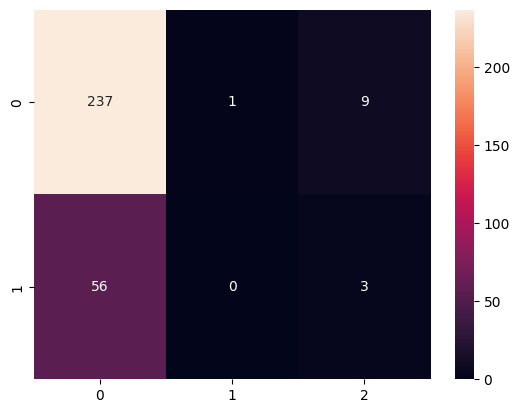

In [ ]:
contingency_matrix = metrics.cluster.contingency_matrix(y_test, y_pred)
snx.heatmap(contingency_matrix, annot = True, fmt='')

In [ ]:
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average = 'macro'))

0.013071895424836602
0.0308571861275178


## Pattern Structure

In [ ]:
pat_cls = fcalc.classifier.PatternBinaryClassifier(ohe_train_sel, y_train,
                                             categorical=np.arange(ohe_train_sel.shape[1]))

In [ ]:
pat_cls.predict(ohe_test_sel)

<Axes: >

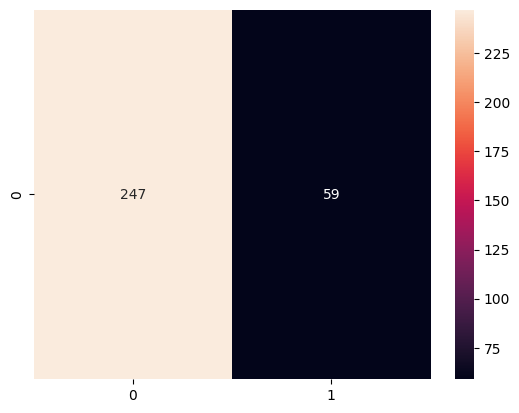

In [ ]:
y_pred = pat_cls.predictions
contingency_matrix = metrics.cluster.contingency_matrix(y_pred, y_test)
snx.heatmap(contingency_matrix, annot = True, fmt='')

In [ ]:
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average = None))

0.0
[0. 0. 0.]
